In [12]:
# Import all packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [13]:
def change_to_list(row):
    amplitudes_string = row['amplitudes'][1:-1]
    amplitude_list = amplitudes_string.split(',')

    map_object = map(int, amplitude_list)
    amplitude_list_int = list(map_object)

    return amplitude_list_int

In [36]:
def get_clustering_results(df, distance_metric = 'euclidean', max_iter = 10, variation_param = 'stddev'):

    # read the csv file

    df['amplitudes'] = df.apply(lambda x: change_to_list(x), axis=1)

    final_data = pd.DataFrame(df['amplitudes'])
    amps = pd.DataFrame(df['amplitudes'].to_list())

    MAX_ITER = max_iter
    DISTANCE_METRIC = distance_metric
    VARIATION_PARAM = variation_param

    # We select best K through best Silhouette score after clustering with different values of K (2 <= K <= 10) 

    silhouette_score_list = []
    dtw_kmeans_final_model = TimeSeriesKMeans()
    max_silhouette_score = 0
    y_pred_final = []

    amps_final = amps.copy()

    for k in np.arange(2,11,1):    
        dtw_kmeans_model_temp = TimeSeriesKMeans(n_clusters=k, metric=DISTANCE_METRIC, 
                                                 max_iter=MAX_ITER, random_state = 101)

        # Special Handling for dtw
        if (DISTANCE_METRIC == 'dtw'):
            amps_new = amps.copy()
            variation_list = []

            length = int(amps_new.shape[1])
            for i in np.arange(0, length, 1):
                df_temp = amps_new.iloc[: , i:i+1]
                value_list = df_temp.values.tolist()
                if (VARIATION_PARAM == 'range'):
                    variation_ = max(value_list)[0] - min(value_list)[0]
                elif (VARIATION_PARAM == 'stddev'):
                    variation_ = np.std(value_list)
                variation_list.append(variation_)

            amps_final_new = amps_new.copy().T
            amps_final_new['range'] = range_list
            amps_final_new = amps_final_new.sort_values(by=['range'], ascending=False).drop(['range'],axis=1).reset_index(drop=True).T
            amps_final = amps_final_new.iloc[: , :2000]

        amps_temp = amps_final.copy()
        y_pred_temp = dtw_kmeans_model_temp.fit_predict(amps_temp)
        amps_temp['combined'] = amps_temp.values.tolist()
        amps_temp['y_pred'] = y_pred_temp
        score_temp = silhouette_score(X = amps_temp.iloc[: , :8704], labels = y_pred_temp, metric = DISTANCE_METRIC)
        silhouette_score_list.append(score_temp)
        max_silhouette_score = max(silhouette_score_list)
        if (max_silhouette_score == score_temp):
            dtw_kmeans_final_model = dtw_kmeans_model_temp
            y_pred_final = y_pred_temp

    NUM_CLUSTERS = silhouette_score_list.index(max_silhouette_score)+2

    final_data['y_pred'] = y_pred_final
    final_data['cluster_center'] = final_data['y_pred'].apply(lambda x:
                                    np.concatenate(dtw_kmeans_final_model.cluster_centers_[x]).ravel().tolist())

    final_data['device_id'] = df['device_id']
    reordered_cols = ['device_id', 'amplitudes', 'y_pred', 'cluster_center']
    final_data = final_data[reordered_cols]

    return final_data, dtw_kmeans_final_model

In [62]:
df_3vac1 = pd.read_csv('Impairment Detection Results/3VAC1_result.csv')

In [63]:
def detect_impairments(data):
    above_0db_noise = data['above_0db_noise_detected']
    ingress = data['ingress_detected']
    notches_or_suckout = data['notches_or_suckouts_detected']
    
    impairment_detected = above_0db_noise or ingress or notches_or_suckout
    
    return impairment_detected

df_3vac1['impairment_detected'] = df_3vac1.apply(lambda x: detect_impairments(x), axis=1)
df_3vac1 = df_3vac1[df_3vac1['impairment_detected'] == 1]

In [39]:
# Clustering

MAX_ITER_ = 10
DISTANCE_METRIC_ = 'euclidean'
VARIATION_PARAM_ = 'stddev'

amps_final, dtw_kmeans_final_model = get_clustering_results(df_3vac1, DISTANCE_METRIC_, MAX_ITER_, VARIATION_PARAM_)

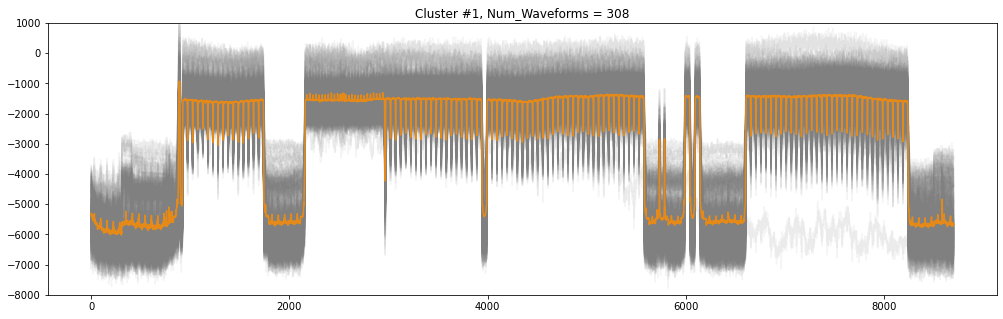

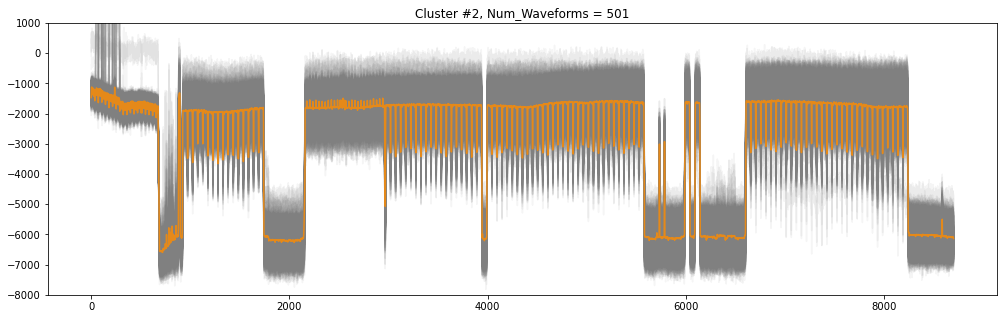

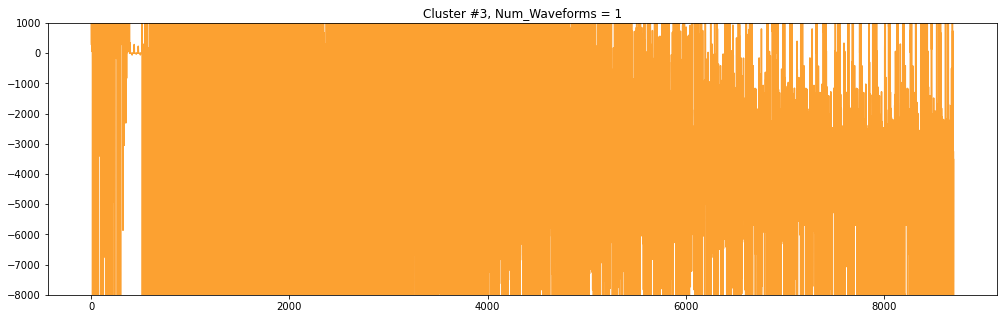

In [42]:
# Plot Clusters

NUM_CLUSTERS = len(set(df_new['y_pred'].tolist()))

amps_clusters = []

for i in np.arange(0, NUM_CLUSTERS, 1):
    amps_clusters.append(amps_final[amps_final['y_pred'] == i]['amplitudes'].reset_index(drop=True))
    
for i in np.arange(0, NUM_CLUSTERS, 1):
    plt.figure(figsize=(17,5))
    for j in np.arange(0, len(amps_clusters[i]), 1):
        plt.plot(amps_clusters[i][j], color='grey', alpha=0.08)
    plt.plot(dtw_kmeans_final_model.cluster_centers_[i], color='darkorange', alpha=0.8)
    num_waveforms_in_cluster = len(amps_clusters[i])
    plt.title('Cluster #{}, Num_Waveforms = {}'.format(i+1, num_waveforms_in_cluster))
    plt.ylim(-8000,1000)
    plt.show()

In [45]:
# Clustering is working as expected
# Cluster 1 has waveforms of a certain type (ingress and notches present)
# Cluster 2 has waveforms of another type (ingress, notches, and above 0db noise present) - the waveform is different
#   from the 1st cluster in the beginning of the spectrum
# Cluster 3 has 1 waveform which seems to be affected a lot by random noise - good that the algorithm has detected it

In [76]:
# Let us investigate the waveform in cluster 3 and check what kind of impairments have been detected by the algorithm

df_3rd_cluster = df_new[df_new['y_pred'] == 2]
index = df_3rd_cluster.index[0]
print(index)
# index is 812

required_index = list(df_3vac1.index).index(index)

df_3vac1.iloc[[required_index]]

812


,device_id,amplitudes,above_0db_noise_detected,ingress_detected,notches_or_suckouts_detected,impairment_detected
812,38:3f:b3:51:7e:36,"[3842, 3188, 975, 343, 273, 4583, 224, 3106, 5...",1,1,0,1


In [77]:
# Algorithm has detected above_0db_noise as well as ingress
# Good enough!